In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from glob import glob
import os
from datetime import datetime
import matplotlib
import matplotlib.patches as patches
import xgboost as xgb

matplotlib.rcParams.update({'errorbar.capsize': 4})

ModuleNotFoundError: No module named 'xgboost'

In [3]:
filtAv = [438, 472, 549, 575, 586, 605, 631, 661, 676, 692]
filtUn = np.array([28, 35, 21, 35, 26, 22, 28, 26, 29, 47]) / 2
filtQE = np.array([0.52654585, 0.61510198, 0.67157561, 0.70026282, 0.71884383, 0.7279477, 0.72530424, 0.71414267, 0.68976776, 0.6438945])


In [36]:
def prepare_spectrum(files, roi):
    nfilt = len(files)
    
    imdark = io.imread(files[-1]).astype(np.int64)
    # img = io.imread(files[0]).astype(np.int64)
    imroi = imdark[roi[0]:roi[1], roi[2]:roi[3]]
    roiSize = imroi.shape[0] * imroi.shape[1]
    offset = 100 * roiSize

    avInt = []
    unInt = []
    for i in range(nfilt-2):
        im = io.imread(files[i]).astype(np.int64)
        img = im - imdark
        imroi = img[roi[0]:roi[1], roi[2]:roi[3]]
        intPx = (imroi.sum() - offset) / roiSize
        avInt.append(intPx)
        
        unPx = np.sqrt((imroi**2).sum()) / roiSize
        unInt.append(unPx)

    avInt = np.array(avInt)
    unInt = np.array(unInt)
    cntQe = avInt / filtQE
    # cntQe /= (filtUn*2)

    unInt /= filtQE
    # unInt /= (filtUn*2)


    return cntQe, unInt

# Spectra diode

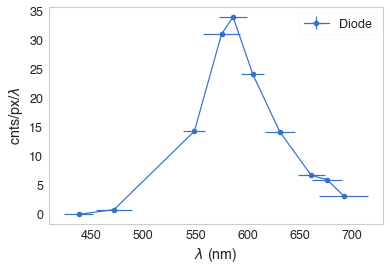

In [40]:
path = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/data/img/sets/08-12-24/Rhodamine-B 50 µM/1'
roi = [1, 2024, 1, 2024]
files = glob(path+'/*.tif')
files.sort()
c, un = prepare_spectrum(files, roi)
c -= c.min()

plt.errorbar(x = filtAv, xerr=filtUn, y = c/(filtUn*2), yerr=un/(filtUn*2), fmt='o-', label='Diode')

plt.gca().set(xlabel='$\lambda$ (nm)', ylabel='cnts/px/$\lambda$')
plt.legend()

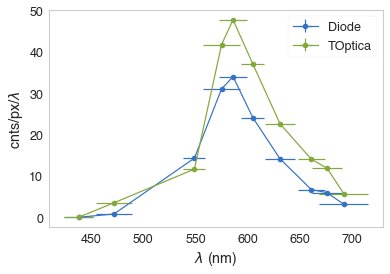

In [41]:
path = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/data/img/sets/08-12-24/Rhodamine-B 50 µM/2'
roi = [1, 2024, 1, 2024]
files = glob(path+'/*.tif')
files.sort()
ct, unt = prepare_spectrum(files, roi)

ct -= ct.min()
ct *= 4.4
unt *= 4.4

plt.errorbar(x = filtAv, xerr=filtUn, y = c/(filtUn*2), yerr=un/(filtUn*2), fmt='o-', label='Diode')
plt.errorbar(x = filtAv, xerr=filtUn, y = ct/(filtUn*2), yerr=unt/(filtUn*2), fmt='o-', label='TOptica')

plt.gca().set(xlabel='$\lambda$ (nm)', ylabel='cnts/px/$\lambda$')
plt.legend()

In [20]:
c.shape, len(filtAv), len(filtUn)

((11,), 10, 9)

In [129]:
SETUP_NAME = "Barium-Tagging"
EXCITATION_FILTER = "Center-527nm_Width-22nm",
DOUBLE_FILTER = "Center-561nm_Width-21nm"
LEFTOVER_FILTER = "Center-500nm_Width-29nm",
LASER_WAVELENGTH = "515nm"
LASER_SOURCE = "TOptica"
DICHROIC_MIRROR_CUTTOFF = "550nm"
N_DMIRRORS = 3
MICROSCOPE_OBJECTIVE = "Mitutoyo_50x_NA_0.5"
exposure = 10
EXPOSURE_TIME = str(exposure)+'s'

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def write_settings_static(fout):

    settings = [SETUP_NAME, LASER_WAVELENGTH, 
                LASER_SOURCE, DICHROIC_MIRROR_CUTTOFF,
                N_DMIRRORS, MICROSCOPE_OBJECTIVE,
                EXPOSURE_TIME]
    # Make a list of strings with the name of the variable and its value:
    fsettings = [f'{namestr(v, globals())[0]}: {v}' for v in settings]  

    with open(fout, 'w') as fo:
        fo.write('\n'.join(fsettings))

def read_settings(fin):
    df_settings = pd.read_csv(fin, sep=':', names=['setting', 'value'], index_col='setting')
    return df_settings



In [26]:
fout = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/data/img/sets/08-12-24/Rhodamine-B 50 µM/1/settings.txt'

write_settings_static(fout)

In [ ]:
df_settings = pd.read_csv(fout, sep=':', names=['setting', 'value'])
print(df_settings)

                   setting                 value
0               SETUP_NAME        Barium-Tagging
1         LASER_WAVELENGTH                 515nm
2             LASER_SOURCE               TOptica
3  DICHROIC_MIRROR_CUTTOFF                 550nm
4               N_DMIRRORS                     3
5     MICROSCOPE_OBJECTIVE   Mitutoyo_50x_NA_0.5
6            EXPOSURE_TIME                   10s


In [ ]:
DICT_MICROSCOPE_OBJECTIVE = {1: "Mitutoyo_50x_NA_0.5",
                             2: "Nikon_60x_NA_0.95"}

DICT_LASER_SOURCE = {1: "TOptica",
                     2: "Diode"}

def edit_dropdown(key, dictionary):
    dropdowns = {'laser': DICT_LASER_SOURCE, 'obj': DICT_MICROSCOPE_OBJECTIVE}
    current_dict = dropdowns[dictionary]
    while True:
        print(f'\nEditing {df_settings.setting[key]} = {df_settings.value[key]}')
        print(current_dict)
        print("\nPress 'q' to quit\n" )

        subkey = input('\nSelect option\n')
        if subkey == 'q':
            break
        elif int(subkey) in current_dict:
            subkey = int(subkey)
            df_settings.loc[subkey, 'value'] = current_dict[subkey]
            break
        else:
            print("invalid key")
            break

def edit_settings():
    while True:
        print(df_settings)
        print("\nPress 'q' to quit\n" )
        key = input('\nSelect key\n')
        if key == 'q':
            break
        elif int(key) in df_settings.index:
            key = int(key)
            if (df_settings.setting[key] == 'LASER_SOURCE'):
                edit_dropdown(key, 'laser')
            elif  (df_settings.setting[key] == 'MICROSCOPE_OBJECTIVE'):
                edit_dropdown(key, 'obj')
            else:
                print(f'\nEditing {df_settings.setting[key]} = {df_settings.value[key]}')
                value = input('\nEnter value:\n')
                df_settings.loc[key, 'value'] = value
        
        else:
            print("invalid key")
            break
        return df_settings

In [100]:
edit_settings()

                   setting                 value
0               SETUP_NAME        Barium-Tagging
1         LASER_WAVELENGTH               TOptica
2             LASER_SOURCE                 Diode
3  DICHROIC_MIRROR_CUTTOFF                 559nm
4               N_DMIRRORS                     2
5     MICROSCOPE_OBJECTIVE   Mitutoyo_50x_NA_0.5
6            EXPOSURE_TIME                   10s

Press 'q' to quit



In [125]:
pathfind = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/data/img/sets/'
def find_recent_settings(pathfind):
    finds = glob(pathfind+'**/**/**/settings.txt')
    dirs = [f[:len(pathfind)+8] for f in finds]
    datestr = [os.path.split(d)[1] for d in dirs]
    dates = [datetime.strptime(dstr, "%d-%m-%y") for dstr in datestr]
    dir_recent = datetime.strftime(max(dates), "%d-%m-%y")
    path_recent = os.path.join(pathfind, dir_recent)
    recent_settings_path = glob(path_recent+'/**/**/settings.txt')[-1]
    return recent_settings_path

In [130]:
recent_settings_path = find_recent_settings(pathfind)
read_settings(recent_settings_path)

,value
setting,
SETUP_NAME,Barium-Tagging
LASER_WAVELENGTH,515nm
LASER_SOURCE,TOptica
DICHROIC_MIRROR_CUTTOFF,550nm
N_DMIRRORS,3
MICROSCOPE_OBJECTIVE,Mitutoyo_50x_NA_0.5
EXPOSURE_TIME,10s
